# Vertical velocity and DIC: Atlantic Sector

In [ ]:
# Not needed for B-SOSE

# tell Python to use the ecco_v4_py in the 'ECCOv4-py' repository
from os.path import join,expanduser
import sys

# identify user's home directory
user_home_dir = expanduser('~')

# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco

import botocore  
import boto3
from boto3.session import Session

import s3fs

In [ ]:
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
import numpy as np
from pathlib import Path
from pprint import pprint
import requests

import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr

import numpy as np
import pandas as pd
import calendar
import gsw
#import warnings

In [ ]:
#warnings.filterwarnings("ignore")

In [ ]:
from dask.distributed import Client

#  connec to existing LocalCluster
# the port number will be different!
client = Client("tcp://127.0.0.1:42155")
client.ncores
client.restart()

In [7]:
# Plotting settings

plt.rcParams['figure.figsize'] = (10, 3)

In [8]:
# local path to monthly-mean MLD dataset
bsose_path = Path('/efs_ecco/alopicco/bsose_data/')

# make a list of all of the files in the directory
bsose_files = np.sort(list(bsose_path.glob('*nc')))

# show first # files
print('\nFirst 20 files')
pprint([x.name for x in bsose_files[:20]])


First 20 files
['ADVrDIC_bsoseI156_2013to2024_monthly.nc',
 'ADVr_SLT_bsoseI156_2013to2024_monthly.nc',
 'ADVr_TH_bsoseI156_2013to2024_monthly.nc',
 'ADVxDIC_bsoseI156_2013to2024_monthly.nc',
 'ADVyDIC_bsoseI156_2013to2024_monthly.nc',
 'DIC_bsoseI156_2013to2024_monthly.nc',
 'Fe_bsoseI156_2013to2024_monthly.nc',
 'MLD_bsoseI156_2013to2024_monthly.nc',
 'NO3_bsoseI156_2013to2024_monthly.nc',
 'NPP_bsoseI156_2013to2024_monthly.nc',
 'Salt_bsoseI156_2013to2024_monthly.nc',
 'Theta_bsoseI156_2013to2024_monthly.nc',
 'WVELSLT_bsoseI156_2013to2024_monthly.nc',
 'WVELTH_bsoseI156_2013to2024_monthly.nc',
 'Wvel_bsoseI156_2013to2024_monthly.nc',
 'grid.nc',
 'surfCO2flx_bsoseI156_2013to2024_monthly.nc']


In [9]:
# local path to monthly-mean MLD dataset
bsose_path = Path('/efs_ecco/alopicco/bsose_data/')

# make a list of all of the files in the directory
bsose_files = np.sort(list(bsose_path.glob('*nc')))

# open dataset
MLD_file = bsose_path / 'MLD_bsoseI156_2013to2024_monthly.nc'
theta_file = bsose_path / 'Theta_bsoseI156_2013to2024_monthly.nc'
salt_file = bsose_path / 'Salt_bsoseI156_2013to2024_monthly.nc'
ADVrDIC_file = bsose_path / 'ADVrDIC_bsoseI156_2013to2024_monthly.nc'
DIC_file = bsose_path / 'DIC_bsoseI156_2013to2024_monthly.nc'
W_file = bsose_path / 'Wvel_bsoseI156_2013to2024_monthly.nc'
grid_file = bsose_path / 'grid.nc'

In [10]:
# start timer
start_time = time.time()

# load the file into memory (note 'load' command at the end)
# ds = xr.open_dataset(theta_file,chunks='auto')
# salt_ds = xr.open_dataset(salt_file,chunks='auto')
# ADVrDIC_ds = xr.open_dataset(ADVrDIC_file,chunks='auto')
# DIC_ds = xr.open_dataset(DIC_file,chunks='auto')
# MLD_ds = xr.open_dataset(MLD_file,chunks='auto')
# W_ds = xr.open_dataset(W_file,chunks='auto')
# grid_ds = xr.open_dataset(grid_file,chunks='auto')

ds = xr.open_dataset(theta_file)
salt_ds = xr.open_dataset(salt_file)
ADVrDIC_ds = xr.open_dataset(ADVrDIC_file)
DIC_ds = xr.open_dataset(DIC_file)
MLD_ds = xr.open_dataset(MLD_file)
W_ds = xr.open_dataset(W_file)
grid_ds = xr.open_dataset(grid_file)

# stop timer
total_time = time.time() - start_time

print('\nloaded theta')
print(f'total time {total_time:.2f} sec')
print('time level : ' , ds.time.values[0])


loaded theta
total time 1.69 sec
time level :  2013-01-30T20:00:00.000000000


In [11]:
# Create maskC_nan
maskC_nan = ds.maskC.where(ds.maskC==True,np.nan)

### DIC and W at different depths temperature

In [12]:
# Depth levels
# 12 corresponds to -105
# 29 corresponds to -500
# 35 corresponds to -1000
# 41 corresponds to -2010
level0 = 0
level100 = 12
level200 = 19
level500 = 29
level1000 = 35
level2000 = 41
levels = [level0,level100,level200,level500,level1000,level2000]
level_depths = [0,100,200,500,1000,2000]

In [13]:
DIC_levels = DIC_ds.TRAC01.isel(Z=levels).where(ds.maskC.isel(Z=levels))

In [14]:
W_levels = xr.DataArray(
    np.full((W_ds.dims['time'], len(levels), W_ds.dims['YC'], W_ds.dims['XC']), np.nan),
    coords={
        'time': W_ds.coords['time'],
        'level': levels,
        'YC': W_ds.coords['YC'],
        'XC': W_ds.coords['XC']
    },
    dims=["time", "level", "YC", "XC"]
)

ADVrDIC_levels = xr.DataArray(
    np.full((W_ds.dims['time'], len(levels), W_ds.dims['YC'], W_ds.dims['XC']), np.nan),
    coords={
        'time': W_ds.coords['time'],
        'level': levels,
        'YC': W_ds.coords['YC'],
        'XC': W_ds.coords['XC']
    },
    dims=["time", "level", "YC", "XC"]
)

/tmp/ipykernel_92/1693328502.py:2: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  np.full((W_ds.dims['time'], len(levels), W_ds.dims['YC'], W_ds.dims['XC']), np.nan),
/tmp/ipykernel_92/1693328502.py:13: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  np.full((W_ds.dims['time'], len(levels), W_ds.dims['YC'], W_ds.dims['XC']), np.nan),


In [15]:
for ti in range(ds.dims['time']):
    for lev in range(len(levels)):
        W_levels[ti,lev,:,:] = (W_ds.WVEL.isel(time=ti).isel(Zl=lev))*(maskC_nan.isel(Z=lev))
        ADVrDIC_levels[ti,lev,:,:] = (ADVrDIC_ds.ADVrTr01.isel(time=ti).isel(Zl=lev))*(maskC_nan.isel(Z=lev))

/tmp/ipykernel_92/2485101988.py:1: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for ti in range(ds.dims['time']):


In [16]:
# Winter and summer months climatology per level

def compute_levels_clim(var):
    """
    Compute monthly climatology and seasonal means (JJA and DJF)
    for a DataArray with a 'time' dimension.
    
    Returns:
        var_levels_clim, var_levels_winter, var_levels_summer
    """
    # Monthly climatology
    var_levels_clim = var.groupby("time.month").mean("time", skipna=True)

    # Replace numeric month index (1–12) with month names
    month_names = [calendar.month_abbr[m] for m in var_levels_clim["month"].values]
    var_levels_clim = var_levels_clim.assign_coords(month=("month", month_names))

    # Seasonal climatology
    var_levels_winter = var_levels_clim.sel(month=["Jun", "Jul", "Aug"]).mean(dim='month', skipna=True)
    var_levels_summer = var_levels_clim.sel(month=["Dec", "Jan", "Feb"]).mean(dim='month', skipna=True)

    return var_levels_clim, var_levels_winter, var_levels_summer

In [17]:
[DIC_levels_clim,DIC_levels_winter,DIC_levels_summer] = compute_levels_clim(DIC_levels)
[W_levels_clim,W_levels_winter,W_levels_summer] = compute_levels_clim(W_levels)
[ADVrDIC_levels_clim,ADVrDIC_levels_winter,ADVrDIC_levels_summer] = compute_levels_clim(ADVrDIC_levels)

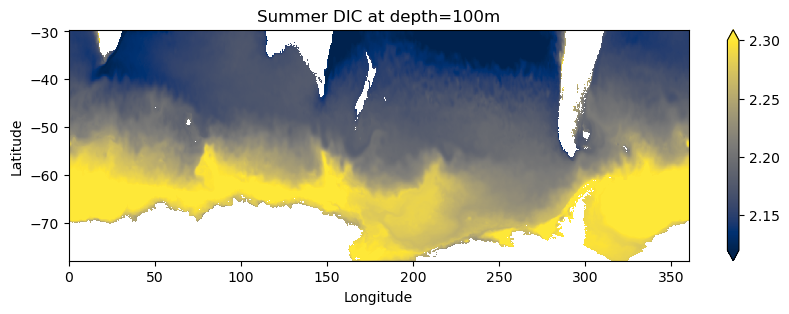

In [18]:
plt.figure()

lev=1
var = DIC_levels_summer[lev,:,:]

vmin = 2.12
vmax = 2.3
plt.pcolormesh(ds.XC, ds.YC, var, vmin=vmin, vmax=vmax, shading='auto', cmap='cividis')
plt.colorbar(extend='both')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Summer DIC at depth={level_depths[lev]}m')

plt.savefig(f"figures_anna/DIC_summer_level{lev}.png", dpi=300, bbox_inches='tight')

plt.show()

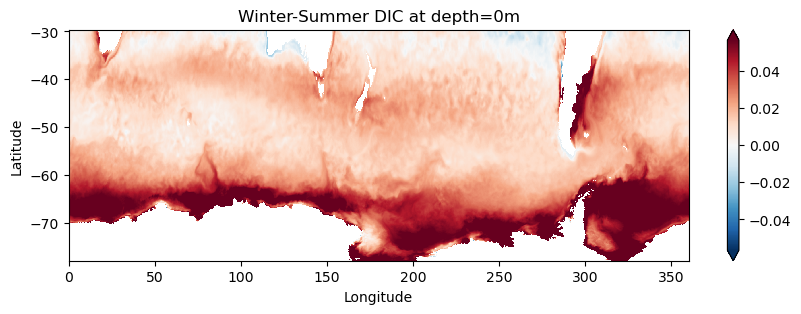

In [19]:
plt.figure()

lev=0
var = (DIC_levels_winter[lev,:,:]-DIC_levels_summer[lev,:,:])

vmax = 0.3*var.max()
vmin = -vmax
plt.pcolormesh(ds.XC, ds.YC, var, vmin=vmin, vmax=vmax, shading='auto', cmap='RdBu_r')
plt.colorbar(extend='both')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Winter-Summer DIC at depth={level_depths[lev]}m')

plt.savefig(f"figures_anna/DIC_seasonal_anomaly_level{lev}.png", dpi=300, bbox_inches='tight')

plt.show()

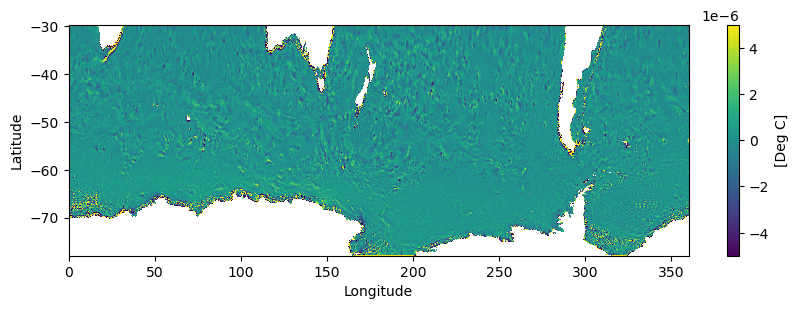

In [38]:
plt.figure()

lev=1
var = W_levels_winter[lev,:,:]

plt.pcolormesh(ds.XC, ds.YC, var, vmin=-5e-6, vmax=5e-6, shading='auto', cmap='viridis')
plt.colorbar(label='[Deg C]')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.title(f'ML Temperature {time_str}')

#plt.savefig("figures_anna/thetaML_sept2021.png", dpi=300, bbox_inches='tight')

plt.show()

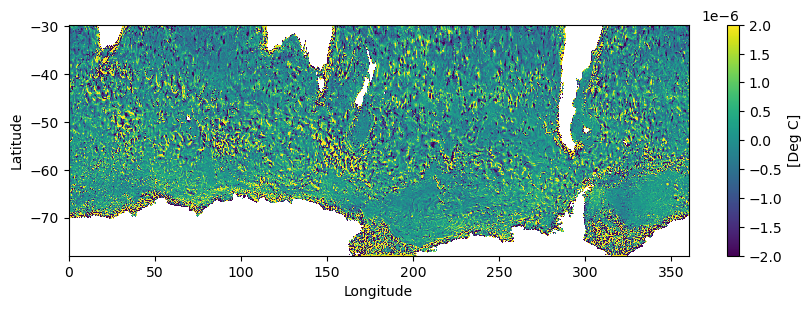

In [57]:
plt.figure()

lev=1
var = W_levels.isel(time=95).isel(level=1)

plt.pcolormesh(ds.XC, ds.YC, var, vmin=-2e-6, vmax=2e-6, shading='auto', cmap='viridis')
plt.colorbar(label='[Deg C]')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.title(f'ML Temperature {time_str}')

#plt.savefig("figures_anna/thetaML_sept2021.png", dpi=300, bbox_inches='tight')

plt.show()

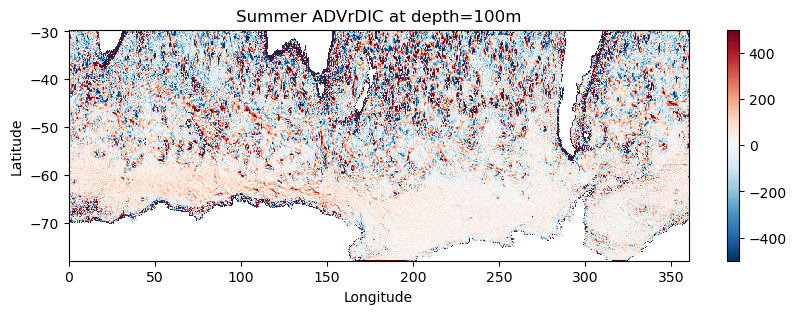

In [37]:
plt.figure()

lev=1
var = ADVrDIC_levels_winter[lev,:,:]

plt.pcolormesh(ds.XC, ds.YC, var, vmin=-500, vmax=500, shading='auto', cmap='RdBu_r')
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Summer ADVrDIC at depth={level_depths[lev]}m')

#plt.savefig(f"figures_anna/ADVrDIC_summer_level{lev}.png", dpi=300, bbox_inches='tight')

plt.show()

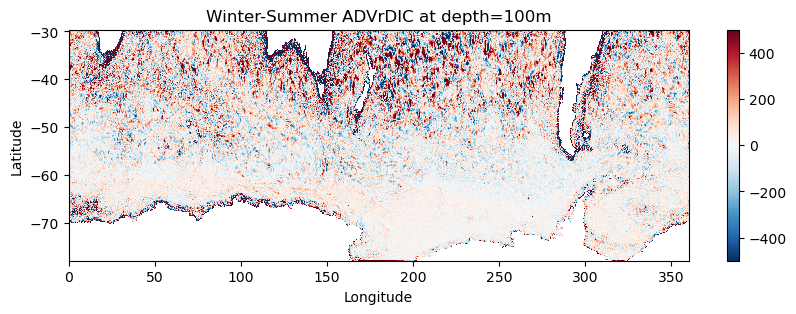

In [36]:
plt.figure()

lev=1
var = ADVrDIC_levels_winter[lev,:,:]-ADVrDIC_levels_summer[lev,:,:]

plt.pcolormesh(ds.XC, ds.YC, var, vmin=-500, vmax=500, shading='auto', cmap='RdBu_r')
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Winter-Summer ADVrDIC at depth={level_depths[lev]}m')

plt.savefig(f"figures_anna/ADVrDIC_seasonal_anomaly_level{lev}.png", dpi=300, bbox_inches='tight')

plt.show()

In [23]:
DIC = DIC_ds.TRAC01

DIC_tot = xr.DataArray(
    np.full((DIC_ds.dims['time'], DIC_ds.dims['YC'], DIC_ds.dims['XC']), np.nan),
    coords={
        'time': DIC_ds.coords['time'],
        'YC': DIC_ds.coords['YC'],
        'XC': DIC_ds.coords['XC']
    },
    dims=["time", "YC", "XC"]
)
for ti in range(ds.dims['time']):
    DIC_tot[ti,:,:] = DIC.isel(time=ti).where(ds.maskC,np.nan).mean(dim='Z',skipna=True)

[DIC_tot_clim,DIC_tot_winter,DIC_tot_summer] = compute_levels_clim(DIC_tot)

/tmp/ipykernel_92/1391982772.py:4: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  np.full((DIC_ds.dims['time'], DIC_ds.dims['YC'], DIC_ds.dims['XC']), np.nan),
/tmp/ipykernel_92/1391982772.py:12: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for ti in range(ds.dims['time']):


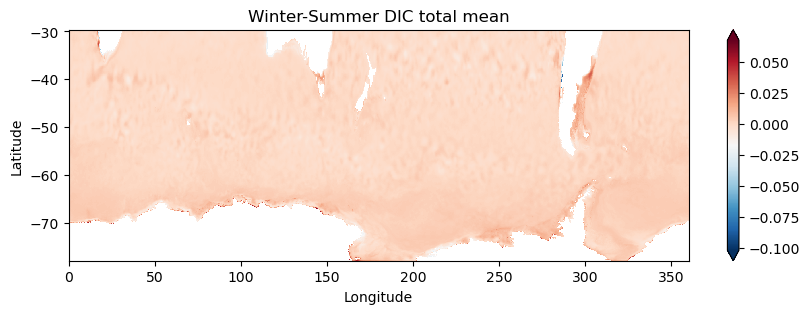

In [24]:
plt.figure()

var = DIC_tot_winter-DIC_tot_summer

vmax = 0.3*var.max()
vmin = -vmax
plt.pcolormesh(ds.XC, ds.YC, var, shading='auto', cmap='RdBu_r')
plt.colorbar(extend='both')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Winter-Summer DIC total mean')

plt.savefig("figures_anna/DIC_seasonal_anomaly_totalmean.png", dpi=300, bbox_inches='tight')

plt.show()

### Atlantic sector

In [25]:
# Define Atlantic sector

box_lon_min, box_lon_max = 300, 360     
box_lat_min, box_lat_max = ds.YC[0].values, ds.YC[-1].values

In [26]:
DIC = DIC_ds.TRAC01

DIC_box = xr.DataArray(
    np.full((DIC_ds.dims['time'], DIC_ds.dims['Z'], DIC_ds.dims['YC']), np.nan),
    coords={
        'time': DIC_ds.coords['time'],
        'Z': DIC_ds.coords['Z'],
        'YC': DIC_ds.coords['YC']
    },
    dims=["time", "Z", "YC"]
)
for ti in range(ds.dims['time']):
    DIC_mask = DIC.isel(time=ti).where(ds.maskC,np.nan)
    DIC_box[ti,:,:] = DIC_mask.sel(XC=slice(box_lon_min, box_lon_max),
        YC=slice(box_lat_min, box_lat_max)).mean(dim='XC',skipna=True)

[DIC_box_clim,DIC_box_winter,DIC_box_summer] = compute_levels_clim(DIC_box)
DIC_box_seasonal_anomaly = DIC_box_winter-DIC_box_summer

/tmp/ipykernel_92/2635458895.py:4: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  np.full((DIC_ds.dims['time'], DIC_ds.dims['Z'], DIC_ds.dims['YC']), np.nan),
/tmp/ipykernel_92/2635458895.py:12: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for ti in range(ds.dims['time']):


In [27]:
ADVrDIC = ADVrDIC_ds.ADVrTr01

ADVrDIC_box = xr.DataArray(
    np.full((ADVrDIC_ds.dims['time'], ADVrDIC_ds.dims['Zl'], ADVrDIC_ds.dims['YC']), np.nan),
    coords={
        'time': ADVrDIC_ds.coords['time'],
        'Zl': ADVrDIC_ds.coords['Zl'],
        'YC': ADVrDIC_ds.coords['YC']
    },
    dims=["time", "Zl", "YC"]
)

for ti in range(ds.dims['time']):
    for zi in range(ADVrDIC_ds.dims['Zl']):
        ADVrDIC_mask = ADVrDIC.isel(time=ti).isel(Zl=zi)*(maskC_nan.isel(Z=zi))
        ADVrDIC_box[ti,zi,:] = ADVrDIC_mask.sel(XC=slice(box_lon_min, box_lon_max),
            YC=slice(box_lat_min, box_lat_max)).mean(dim='XC',skipna=True)

[ADVrDIC_box_clim,ADVrDIC_box_winter,ADVrDIC_box_summer] = compute_levels_clim(ADVrDIC_box)
ADVrDIC_box_seasonal_anomaly = ADVrDIC_box_winter-ADVrDIC_box_summer

/tmp/ipykernel_92/1266166001.py:4: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  np.full((ADVrDIC_ds.dims['time'], ADVrDIC_ds.dims['Zl'], ADVrDIC_ds.dims['YC']), np.nan),
/tmp/ipykernel_92/1266166001.py:13: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for ti in range(ds.dims['time']):
/tmp/ipykernel_92/1266166001.py:14: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for zi in range(ADVrDIC_d

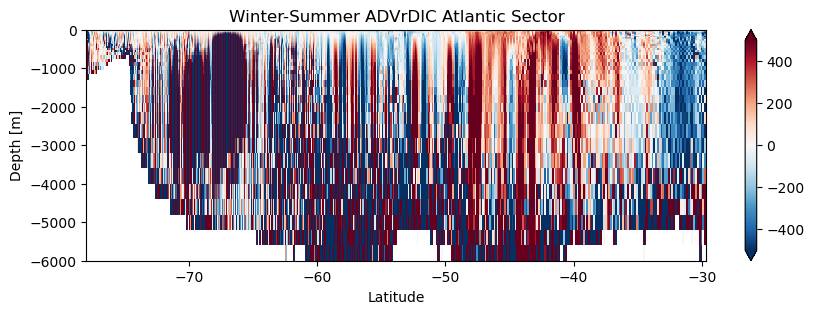

In [28]:
plt.figure()

var = ADVrDIC_box_winter-ADVrDIC_box_summer

vmax = 500
vmin = -vmax
plt.pcolormesh(ds.YC, ds.Z, var, vmin=vmin, vmax=vmax, shading='auto', cmap='RdBu_r')
plt.colorbar(extend='both')
plt.xlabel('Latitude')
plt.ylabel('Depth [m]')
plt.title(f'Winter-Summer ADVrDIC Atlantic Sector')
#plt.ylim(-200,0)

plt.savefig(f"figures_anna/ADVrDIC_seasonal_anomaly_atl.png", dpi=300, bbox_inches='tight')

plt.show()

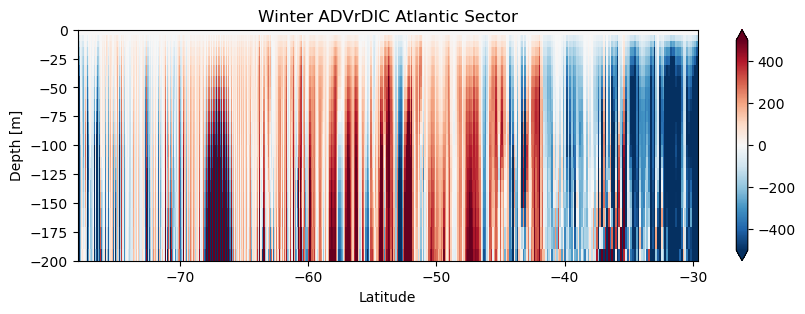

In [32]:
plt.figure()

var = ADVrDIC_box_winter

vmax = 500
vmin = -vmax
plt.pcolormesh(ds.YC, ds.Z, var, vmin=vmin, vmax=vmax, shading='auto', cmap='RdBu_r')
plt.colorbar(extend='both')
plt.xlabel('Latitude')
plt.ylabel('Depth [m]')
plt.title(f'Winter ADVrDIC Atlantic Sector')
plt.ylim(-200,0)

#plt.savefig(f"figures_anna/ADVrDIC_winter_atl.png", dpi=300, bbox_inches='tight')

plt.show()

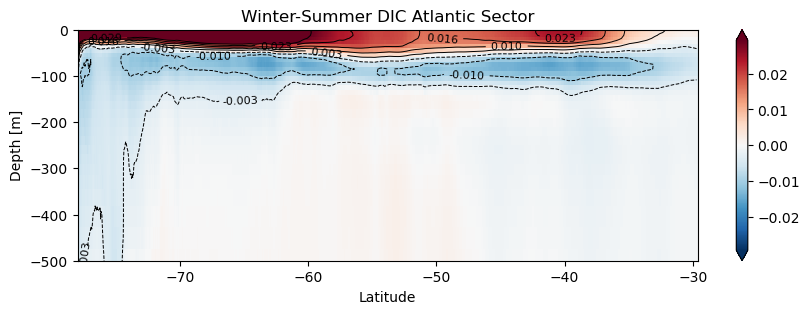

In [61]:
plt.figure()

var = DIC_box_seasonal_anomaly

vmax = 0.3*var.max().values
vmin = -vmax
plt.pcolormesh(ds.YC, ds.Z, var, vmin=vmin, vmax=vmax, shading='auto', cmap='RdBu_r')
plt.colorbar(extend='both')
plt.xlabel('Latitude')
plt.ylabel('Depth [m]')
plt.title(f'Winter-Summer DIC Atlantic Sector')
plt.ylim(-500,0)

# Add contour lines
contour_levels = np.linspace(vmin, vmax, 10)
cs = plt.contour(ds.YC, ds.Z, var, levels=contour_levels, colors='k', linewidths=0.7)
plt.clabel(cs, fmt="%.3f", fontsize=8)

plt.savefig(f"figures_anna/DIC_seasonal_anomaly_atl_500mdepth.png", dpi=300, bbox_inches='tight')

plt.show()

### DIC considering MLD in the boxes

In [62]:
# Create MLD_mask
MLD_mask = MLD_ds.BLGMLD.where(ds.maskInC, np.nan)

# MLD in the Atlantic sector
MLD_box = MLD_mask.sel(XC=slice(box_lon_min, box_lon_max),
        YC=slice(box_lat_min, box_lat_max)).mean(dim='XC',skipna=True)

[MLD_box_clim,MLD_box_winter,MLD_box_summer] = compute_levels_clim(MLD_box)

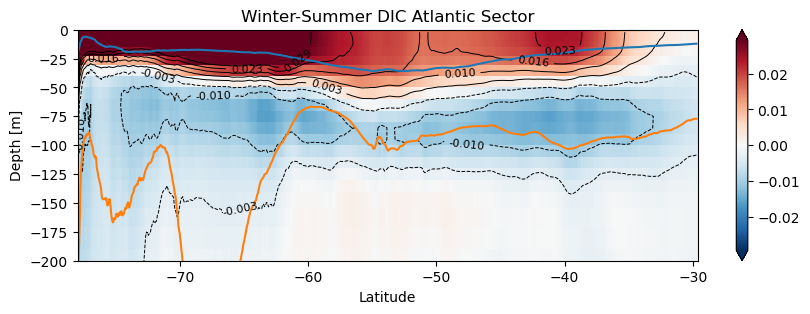

In [63]:
plt.figure()

var = DIC_box_seasonal_anomaly

vmax = 0.3*var.max().values
vmin = -vmax
plt.pcolormesh(ds.YC, ds.Z, var, vmin=vmin, vmax=vmax, shading='auto', cmap='RdBu_r')
plt.colorbar(extend='both')
plt.xlabel('Latitude')
plt.ylabel('Depth [m]')
plt.title(f'Winter-Summer DIC Atlantic Sector')
plt.ylim(-200,0)

# Add contour lines
contour_levels = np.linspace(vmin, vmax, 10)
cs = plt.contour(ds.YC, ds.Z, var, levels=contour_levels, colors='k', linewidths=0.7)
plt.clabel(cs, fmt="%.3f", fontsize=8)

# Add MLD
plt.plot(ds.YC,-MLD_box_summer)
plt.plot(ds.YC,-MLD_box_winter)

plt.savefig(f"figures_anna/DIC_seasonal_anomaly_atl_MLD.png", dpi=300, bbox_inches='tight')

plt.show()

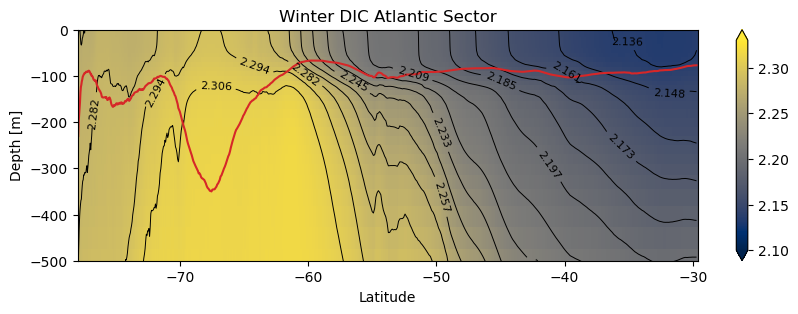

In [64]:
plt.figure()

var = DIC_box_winter

vmax = 2.33
vmin = 2.1
plt.pcolormesh(ds.YC, ds.Z, var, vmin=vmin, vmax=vmax, shading='auto', cmap='cividis')
plt.colorbar(extend='both')
plt.xlabel('Latitude')
plt.ylabel('Depth [m]')
plt.title(f'Winter DIC Atlantic Sector')
plt.ylim(-500,0)

# Add contour lines
contour_levels = np.linspace(vmin, vmax, 20)
cs = plt.contour(ds.YC, ds.Z, var, levels=contour_levels, colors='k', linewidths=0.7)
plt.clabel(cs, fmt="%.3f", fontsize=8)

# Add MLD
plt.plot(ds.YC,-MLD_box_winter,color='tab:red')

plt.savefig(f"figures_anna/DIC_winter_atl_MLD.png", dpi=300, bbox_inches='tight')

plt.show()

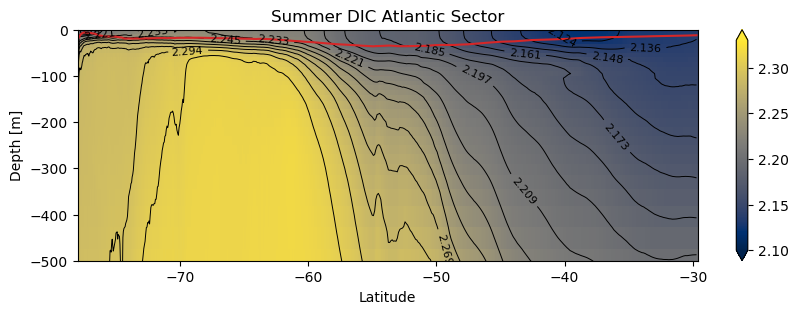

In [65]:
plt.figure()

var = DIC_box_summer

vmax = 2.33
vmin = 2.1
plt.pcolormesh(ds.YC, ds.Z, var, vmin=vmin, vmax=vmax, shading='auto', cmap='cividis')
plt.colorbar(extend='both')
plt.xlabel('Latitude')
plt.ylabel('Depth [m]')
plt.title(f'Summer DIC Atlantic Sector')
plt.ylim(-500,0)

# Add contour lines
contour_levels = np.linspace(vmin, vmax, 20)
cs = plt.contour(ds.YC, ds.Z, var, levels=contour_levels, colors='k', linewidths=0.7)
plt.clabel(cs, fmt="%.3f", fontsize=8)

# Add MLD
plt.plot(ds.YC,-MLD_box_summer,color='tab:red')

plt.savefig(f"figures_anna/DIC_summer_atl_MLD.png", dpi=300, bbox_inches='tight')

plt.show()

### DIC with isopycnals

In [67]:
theta_box = xr.DataArray(
    np.full((ds.dims['time'], ds.dims['Z'], ds.dims['YC']), np.nan),
    coords={
        'time': ds.coords['time'],
        'Z': ds.coords['Z'],
        'YC': ds.coords['YC']
    },
    dims=["time", "Z", "YC"]
)
for ti in range(ds.dims['time']):
    theta_mask = ds.THETA.isel(time=ti).where(ds.maskC,np.nan)
    theta_box[ti,:,:] = theta_mask.sel(XC=slice(box_lon_min, box_lon_max),
        YC=slice(box_lat_min, box_lat_max)).mean(dim='XC',skipna=True)

[theta_box_clim,theta_box_winter,theta_box_summer] = compute_levels_clim(theta_box)
theta_box_seasonal_anomaly = theta_box_winter-theta_box_summer

/tmp/ipykernel_92/3216461179.py:2: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  np.full((ds.dims['time'], ds.dims['Z'], ds.dims['YC']), np.nan),
/tmp/ipykernel_92/3216461179.py:10: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for ti in range(ds.dims['time']):


In [69]:
salt_box = xr.DataArray(
    np.full((ds.dims['time'], ds.dims['Z'], ds.dims['YC']), np.nan),
    coords={
        'time': ds.coords['time'],
        'Z': ds.coords['Z'],
        'YC': ds.coords['YC']
    },
    dims=["time", "Z", "YC"]
)
for ti in range(ds.dims['time']):
    salt_mask = salt_ds.SALT.isel(time=ti).where(ds.maskC,np.nan)
    salt_box[ti,:,:] = salt_mask.sel(XC=slice(box_lon_min, box_lon_max),
        YC=slice(box_lat_min, box_lat_max)).mean(dim='XC',skipna=True)

[salt_box_clim,salt_box_winter,salt_box_summer] = compute_levels_clim(salt_box)
salt_box_seasonal_anomaly = salt_box_winter-salt_box_summer

/tmp/ipykernel_92/3391754950.py:2: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  np.full((ds.dims['time'], ds.dims['Z'], ds.dims['YC']), np.nan),
/tmp/ipykernel_92/3391754950.py:10: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for ti in range(ds.dims['time']):


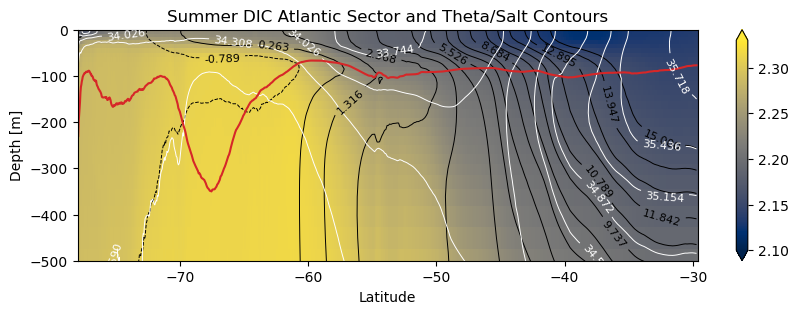

In [82]:
plt.figure()

var = DIC_box_summer

vmax = 2.33
vmin = 2.1
plt.pcolormesh(ds.YC, ds.Z, var, vmin=vmin, vmax=vmax, shading='auto', cmap='cividis')
plt.colorbar(extend='both')
plt.xlabel('Latitude')
plt.ylabel('Depth [m]')
plt.title(f'Summer DIC Atlantic Sector and Theta/Salt Contours')
plt.ylim(-500,0)

# Add contour lines
var = theta_box_summer
vmax = 15
vmin = -5
contour_levels = np.linspace(vmin, vmax, 20)
cs = plt.contour(ds.YC, ds.Z, var, levels=contour_levels, colors='k', linewidths=0.7)
plt.clabel(cs, fmt="%.3f", fontsize=8)

# Add contour lines
var = salt_box_summer
vmax = 36
vmin = 25
contour_levels = np.linspace(vmin, vmax, 40)
cs = plt.contour(ds.YC, ds.Z, var, levels=contour_levels, colors='white', linewidths=0.7)
plt.clabel(cs, fmt="%.3f", fontsize=8)

# Add MLD
plt.plot(ds.YC,-MLD_box_winter,color='tab:red')

plt.savefig(f"figures_anna/DIC_summer_atl_MLD_thetasaltcontours.png", dpi=300, bbox_inches='tight')

plt.show()